# Sound Classification Data Exploration

This notebook is intended for initial exploration and analysis of the sound datasets used in the home sound classification project. We will load the datasets, visualize sound data, and perform exploratory data analysis.

FIRST STEP - DATA PRE PROCESSING

In [1]:
import soundata

dataset = soundata.initialize('urbansound8k')
dataset.download()  # download the dataset
dataset.validate()  # validate that all the expected files are there

INFO: Downloading ['all', 'index']. Index is being stored in C:\Users\ebd-marco\Documents\homeaudio_ml\homeaudio\Lib\site-packages\soundata\datasets\indexes, and the rest of files in /tmp\sound_datasets\urbansound8k
INFO: [all] downloading UrbanSound8K.tar.gz
INFO: /tmp\sound_datasets\urbansound8k\UrbanSound8K.tar.gz already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: /tmp\sound_datasets\urbansound8k\audio already exists. Run with force_overwrite=True to download from scratch
INFO: /tmp\sound_datasets\urbansound8k\FREESOUNDCREDITS.txt already exists. Run with force_overwrite=True to download from scratch
INFO: /tmp\sound_datasets\urbansound8k\metadata already exists. Run with force_overwrite=True to download from scratch
INFO: /tmp\sound_datasets\urbansound8k\UrbanSound8K_README.txt already exists. Run with force_overwrite=True to download from scratch
INFO: [index] downloading urbansound8k_index_1.0.json
INFO: C:

({'metadata': {}, 'clips': {}}, {'metadata': {}, 'clips': {}})

In [2]:
example_clip = dataset.choice_clip()  # choose a random example clip
print(example_clip)  # see the available data

Clip(
  audio_path="/tmp\sound_datasets\urbansound8k\audio/fold4/144007-5-1-4.wav",
  clip_id="144007-5-1-4",
  audio: The clip's audio
            * np.ndarray - audio signal
            * float - sample rate,
  class_id: The clip's class id.
            * int - integer representation of the class label (0-9). See Dataset Info in the documentation for mapping,
  class_label: The clip's class label.
            * str - string class name: air_conditioner, car_horn, children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, street_music,
  fold: The clip's fold.
            * int - fold number (1-10) to which this clip is allocated. Use these folds for cross validation,
  freesound_end_time: The clip's end time in Freesound.
            * float - end time in seconds of the clip in the original freesound recording,
  freesound_id: The clip's Freesound ID.
            * str - ID of the freesound.org recording from which this clip was taken,
  freesound_start_time: Th

In [3]:
import librosa
example_path = example_clip.audio_path
audio, audio_sr = librosa.load(example_path) #audio = numpy array ||| audio_sr = int

In [4]:
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr = audio_sr) #raw mel spectrogram

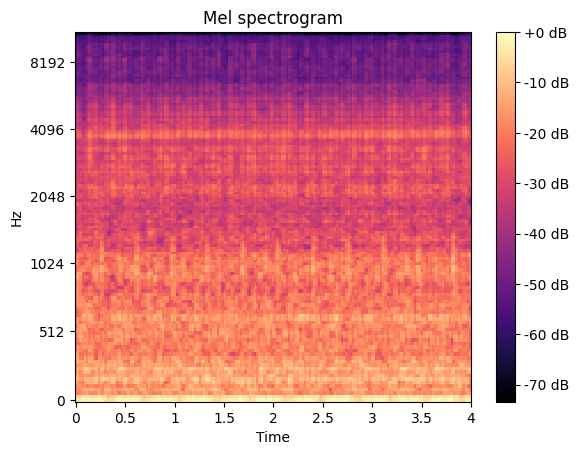

In [5]:
import librosa.feature
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

#Convert spectrogram to db
mel_spectrogram_db = librosa.power_to_db(S = mel_spectrogram, ref = np.max)

#Plot the spectrogram
fig, ax = plt.subplots()
img = librosa.display.specshow(mel_spectrogram_db, x_axis = 'time', y_axis = 'mel', sr = audio_sr, ax = ax)

#Add color bar and title for clarity
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel spectrogram')

#Show the plot
plt.show()

In [6]:
desired_time = 4#s
mel_spectrograms = []
clip_labels = []

for clip_id in dataset.clip_ids:
    clip = dataset.clip(clip_id)
    audio, sampling_rate = librosa.load(clip.audio_path)
    duration = len(audio)/sampling_rate
    
    if duration < desired_time:
        num_points = int(desired_time*sampling_rate) - len(audio)
        formatted_clip = np.pad(audio, (0, num_points), 'constant')
    else:
        desired_length = int(desired_time*sampling_rate)
        formatted_clip = audio[:desired_length]

    mel_spectrograms.append(librosa.feature.melspectrogram(y=formatted_clip, sr = sampling_rate))
    clip_labels.append(clip.class_label)
    

In [14]:
import tensorflow as tf
input_shape = (128, 250, 1)
pool_size = (2,2)

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32,
                          kernel_size=(3,3),
                          activation='relu', 
                          input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size = pool_size),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
                 ])

In [17]:
cnn_model.compile(optimizer= 'adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [30]:
spectrograms_np = np.array(mel_spectrograms)
spectrograms_np = np.expand_dims(spectrograms_np, axis=-1)

class_names = sorted(list(set(clip_labels)))

label_to_id = {name: i for i, name in enumerate(class_names)}

all_labels_id = [label_to_id[label] for label in clip_labels]

labels_np = np.array(all_labels_id)

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(spectrograms_np, labels_np, test_size = 0.2, random_state = 42)

history = cnn_model.fit(x_train,
                        y_train,
                        epochs = 20,
                        batch_size = 32,
                        validation_data = (x_val,y_val),
                        verbose=1
                       )

Epoch 1/20


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 249984, but received input with shape (None, 171360)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 128, 173, 1), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>